<h3> Homework - California Housing Prices </h3>

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

In [3]:
# Read the data
housing = pd.read_csv('housing.csv', verbose=True)

Tokenization took: 30.00 ms
Type conversion took: 17.00 ms
Parser memory cleanup took: 0.00 ms


In [4]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


<h3> Calculating Correlation </h3>

In [5]:
# Checking for correlations
housing_numeric = housing.select_dtypes(include=np.number)
housing_numeric.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


Text(0.5, 1.0, '')

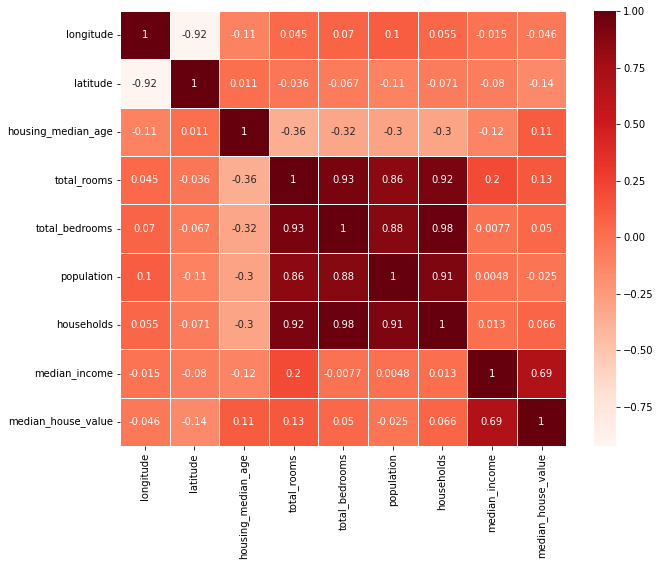

In [34]:
# Plotting heatmap
plt.figure(figsize=((10, 8)))
sns.heatmap(housing_numeric.corr(), 
            annot=True, linewidths=0.5, cmap='Reds')
plt.title('Heatmap show')


In [7]:
housing.nunique()

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
median_house_value     3842
ocean_proximity           5
dtype: int64

In [8]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [9]:
housing.isna().sum()
housing['total_bedrooms'].fillna(0, inplace=True)

In [10]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
# Creating a new column - rooms_per_household
# housing['rooms_per_household'] = housing['households'] / housing['total_rooms'] * 100
# housing.drop('rooms_per_household', axis=1, inplace=True)
housing.insert(7, 'rooms_per_household', 
               round(housing['households'] / housing['total_rooms'] * 100, 2))

In [12]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,rooms_per_household,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,14.32,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,16.03,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,12.07,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,17.19,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,15.92,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,19.82,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,16.36,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,19.21,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,18.76,1.8672,84700.0,INLAND


In [13]:
# Creating another column - bedrooms_per_room
housing.insert(5, 'bedrooms_per_room', \
                round(housing['total_bedrooms'] / housing['total_rooms'] * 100, 2))

In [14]:
# Creating another column - population_per_household
housing.insert(9, 'population_per_household',
               round(housing['population'] / housing['households'] * 100, 2))

In [15]:
# Question 1
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'bedrooms_per_room', 'population', 'households',
       'rooms_per_household', 'population_per_household', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [16]:
# Getting the most frequent observation for ocean proximity
most_frequent_name = housing['ocean_proximity'].value_counts().index[0]
most_frequent_value = housing['ocean_proximity'].value_counts().values[0]
print(f"The most frequent value in the ocean proximity column is \
        {most_frequent_name} with a value of {most_frequent_value}")


The most frequent value in the ocean proximity column is         <1H OCEAN with a value of 9136


<h3> Creating a correlation matrix </h3>

In [17]:
housing.corr(numeric_only=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,bedrooms_per_room,population,households,rooms_per_household,population_per_household,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.068082,0.084833,0.099773,0.055310,0.082801,0.002476,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.065318,-0.104106,-0.108785,-0.071035,-0.146876,0.002366,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.317063,0.125396,-0.296244,-0.302916,0.195010,0.013191,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.920196,-0.174590,0.857126,0.918484,-0.217211,-0.024581,0.198050,0.134153
total_bedrooms,0.068082,-0.065318,-0.317063,0.920196,1.000000,0.122197,0.866266,0.966507,0.020245,-0.028019,-0.007295,0.049148
bedrooms_per_room,0.084833,-0.104106,0.125396,-0.174590,0.122197,1.000000,0.031389,0.059809,0.827404,0.003051,-0.573837,-0.238761
population,0.099773,-0.108785,-0.296244,0.857126,0.866266,0.031389,1.000000,0.907222,0.053130,0.069863,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.966507,0.059809,0.907222,1.000000,0.064700,-0.027309,0.013033,0.065843
rooms_per_household,0.082801,-0.146876,0.195010,-0.217211,0.020245,0.827404,0.053130,0.064700,1.000000,0.011485,-0.536587,-0.214649
population_per_household,0.002476,0.002366,0.013191,-0.024581,-0.028019,0.003051,0.069863,-0.027309,0.011485,1.000000,0.018766,-0.023737


In [18]:
y_original = housing.median_house_value

<h3> Converting target variable to binary </h3>

In [19]:
median_housing_mean = housing['median_house_value'].mean()

# housing['median_house_value'] = 1 if housing['median_house_value'] > median_housing_mean \
#                                     else 0

for i in range(len(housing['median_house_value'])):
    if housing['median_house_value'][i] > median_housing_mean:
        housing['median_house_value'][i] = 1
    else:
        housing['median_house_value'][i] = 0


C:\Users\Latitude E7270\AppData\Local\Temp\ipykernel_15968\3907159521.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing['median_house_value'][i] = 1
C:\Users\Latitude E7270\AppData\Local\Temp\ipykernel_15968\3907159521.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing['median_house_value'][i] = 0


<h3> Splitting the data </h3>

In [20]:
X = housing.drop('median_house_value', axis=1)
y = housing['median_house_value']


In [21]:
dummies = pd.get_dummies(X.ocean_proximity)
dummies = dummies.drop('<1H OCEAN', axis=1)

X = X.drop('ocean_proximity', axis=1)

X = pd.concat([X, dummies], axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y_original, test_size=0.20,
                                                    random_state=22)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, random_state=22)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
# X_train.dtypes
y_train.shape

(13209,)

In [23]:
# Getting the mutual info score for the ocean proximity feature

from sklearn.feature_selection import mutual_info_classif, mutual_info_classif


mutual_info = mutual_info_score(housing['ocean_proximity'], y)

score = round(mutual_info, 3)

print(f'The mutual info score for ocean proximity is {score}')

The mutual info score for ocean proximity is 0.102


<h3> Training a Linear Regression Model </h3>

In [24]:
model = LogisticRegression(solver="liblinear", C=1.0,
                           max_iter=1000, random_state=42)

model.fit(X_train, y_train)
score = model.score(X_val, y_val)
score = round(score*100, 2)

print(f"The model accuracy score is {score}%")

The model accuracy score is 82.68%


In [25]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,bedrooms_per_room,population,households,rooms_per_household,population_per_household,median_income,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-117.12,32.58,34.0,2003.0,466.0,23.27,1226.0,443.0,22.12,276.75,3.0613,0,0,0,1
1,-121.84,37.38,33.0,835.0,181.0,21.68,781.0,169.0,20.24,462.13,5.1082,0,0,0,0
2,-118.39,34.00,40.0,1565.0,269.0,17.19,826.0,268.0,17.12,308.21,5.2035,0,0,0,0
3,-119.71,36.88,17.0,2236.0,315.0,14.09,992.0,312.0,13.95,317.95,6.9405,1,0,0,0
4,-121.25,37.97,41.0,855.0,189.0,22.11,716.0,206.0,24.09,347.57,2.0375,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13204,-118.52,34.26,21.0,8850.0,2139.0,24.17,4717.0,1979.0,22.36,238.35,3.7816,0,0,0,0
13205,-120.40,37.98,19.0,2010.0,433.0,21.54,910.0,390.0,19.40,233.33,2.6696,1,0,0,0
13206,-117.21,32.86,16.0,2800.0,566.0,20.21,1267.0,518.0,18.50,244.59,3.2794,0,0,0,1
13207,-118.26,33.91,39.0,967.0,256.0,26.47,903.0,256.0,26.47,352.73,1.9038,0,0,0,0


<h3> Finding the least useful feature </h3>

In [26]:
# Train set
train_1 = X_train[['total_rooms', 'total_bedrooms', 'population', 'households']]
train_2 = X_train[['total_rooms', 'total_bedrooms', 'population']] # ~households
train_3 = X_train[['total_rooms', 'total_bedrooms','households']] # ~population
train_4 = X_train[['total_rooms', 'population', 'households']] # ~total bedrooms
train_5 = X_train[['total_bedrooms', 'population', 'households']] # ~total rooms

# Validation set
val_1 = X_val[['total_rooms', 'total_bedrooms', 'population', 'households']]
val_2 = X_val[['total_rooms', 'total_bedrooms', 'population']] # ~households
val_3 = X_val[['total_rooms', 'total_bedrooms', 'households']]  # ~population
val_4 = X_val[['total_rooms', 'population', 'households']]  # ~total bedrooms
val_5 = X_val[['total_bedrooms', 'population', 'households']]  # ~total rooms


In [27]:
model = LogisticRegression(solver="liblinear", C=1.0,
                           max_iter=1000, random_state=42)

model.fit(train_1, y_train)
score = model.score(val_1, y_val)
score = round(score*100, 2)

print(f"Train features: {train_1.columns}")
print(f"Validation features: {val_1.columns}")
print(f"The model accuracy score is {score}%")


Train features: Index(['total_rooms', 'total_bedrooms', 'population', 'households'], dtype='object')
Validation features: Index(['total_rooms', 'total_bedrooms', 'population', 'households'], dtype='object')
The model accuracy score is 69.18%


In [28]:
sets = [(train_2, y_train, val_2, y_val), (train_3, y_train, val_3, y_val),
              (train_4, y_train, val_4, y_val), (train_5, y_train, val_5, y_val)
    ]
    # model.fit(train_4, y_train)
    # model.score(val_4, y_val)
C = 1

for set in sets:
    model = LogisticRegression(solver="liblinear", C=C,
                               max_iter=1000, random_state=42)
    model.fit(set[0], set[1])
    score = model.score(set[2], set[3])
    score = round(score, 2)
    print(f'Train set: {set[0].columns}')
    print(f'Validation set: {set[2].columns}')
    print(score)

Train set: Index(['total_rooms', 'total_bedrooms', 'population'], dtype='object')
Validation set: Index(['total_rooms', 'total_bedrooms', 'population'], dtype='object')
0.67
Train set: Index(['total_rooms', 'total_bedrooms', 'households'], dtype='object')
Validation set: Index(['total_rooms', 'total_bedrooms', 'households'], dtype='object')
0.65
Train set: Index(['total_rooms', 'population', 'households'], dtype='object')
Validation set: Index(['total_rooms', 'population', 'households'], dtype='object')
0.66
Train set: Index(['total_bedrooms', 'population', 'households'], dtype='object')
Validation set: Index(['total_bedrooms', 'population', 'households'], dtype='object')
0.62


In [29]:
alpha = [0, 0.01, 0.1, 1, 10]

for val in alpha:
    model = Ridge(alpha=val, solver="sag", random_state=42)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)
    # rmse = model.mean_square_error(predict, y_val)

    def rmse(y, y_pred):
        error = y - y_pred
        squared_error = error ** 2
        mean_squared_error = squared_error.mean()

        return np.sqrt(mean_squared_error)

In [30]:
for val in tqdm(alpha):
    model = Ridge(alpha=val, solver="sag", random_state=42)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)
    error = rmse(y_val, predict)
    print(error)
    # print(round(error, 2))

  0%|          | 0/5 [00:00<?, ?it/s]

0.4633691778767974
0.4633691778767974
0.46336917787817933
0.46336917789199794
0.46336917802949457


<h3> Save the model using pickle </h3>

In [31]:
with open(f'model_C={C}.bin', 'wb') as out_file:
    pickle.dump(model, out_file)

<h3> Load the model </h3>